<a href="https://colab.research.google.com/github/Thandow/BiasFairnessAnalysis/blob/main/Fairness_Analysis_Recidivism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os

os.listdir('/content')

['.config', 'Recidivism__Beginning_2008.csv', 'sample_data']

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
file_path = "/content/Recidivism__Beginning_2008.csv"
df = pd.read_csv(file_path)

df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status
0,2008,UNKNOWN,MALE,55,Not Returned
1,2008,ALBANY,MALE,16,Returned Parole Violation
2,2008,ALBANY,MALE,17,Not Returned
3,2008,ALBANY,MALE,17,Returned Parole Violation
4,2008,ALBANY,MALE,18,Not Returned


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287139 entries, 0 to 287138
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Release Year          287139 non-null  int64 
 1   County of Indictment  287139 non-null  object
 2   Gender                287139 non-null  object
 3   Age at Release        287139 non-null  int64 
 4   Return Status         287139 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.0+ MB


In [43]:
df.describe()

,Release Year,Age at Release
count,287139.000000,287139.000000
mean,2013.572907,35.969844
std,3.710050,11.174744
min,2008.000000,16.000000
25%,2010.000000,27.000000
50%,2013.000000,34.000000
75%,2017.000000,44.000000
max,2020.000000,100.000000


In [45]:
df.isnull().sum()

,0
Release Year,0
County of Indictment,0
Gender,0
Age at Release,0
Return Status,0


In [47]:
features = [
    'Age at Release',
    'County of Indictment'
]

label = 'Return Status'
protected_attr = 'Gender'

df = df[features + [label, protected_attr]]
df.dropna(inplace=True)

df.head()

,Age at Release,County of Indictment,Return Status,Gender
0,55,UNKNOWN,Not Returned,MALE
1,16,ALBANY,Returned Parole Violation,MALE
2,17,ALBANY,Not Returned,MALE
3,17,ALBANY,Returned Parole Violation,MALE
4,18,ALBANY,Not Returned,MALE


In [49]:
df['returned'] = df['Return Status'].apply(
    lambda x: 1 if 'Returned' in x else 0
)

In [51]:
df['gender_binary'] = df['Gender'].apply(
    lambda x: 1 if x == 'MALE' else 0
)

In [53]:
df_encoded = pd.get_dummies(
    df,
    columns=['County of Indictment'],
    drop_first=True
)

In [55]:
X = df_encoded.drop(columns=['Return Status', 'Gender', 'returned', 'gender_binary'])
y = df_encoded['returned']
protected = df_encoded['gender_binary']

print(X.shape, y.shape, protected.shape)

(287139, 63) (287139,) (287139,)


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Model accuracy:", model.score(X_test, y_test))

Model accuracy: 0.9151401174804393


In [59]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    X, y, protected, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [63]:
import numpy as np

def demographic_parity_difference(y_pred, protected):
    p_unpriv = np.mean(y_pred[protected == 0])
    p_priv = np.mean(y_pred[protected == 1])
    return p_unpriv - p_priv

dpd = demographic_parity_difference(y_pred, prot_test.values)
print("Demographic Parity Difference:", dpd)

Demographic Parity Difference: 0.0


In [65]:
def equal_opportunity_difference(y_true, y_pred, protected):
    tpr_unpriv = np.mean(
        y_pred[(protected == 0) & (y_true == 1)]
    )
    tpr_priv = np.mean(
        y_pred[(protected == 1) & (y_true == 1)]
    )
    return tpr_unpriv - tpr_priv

eod = equal_opportunity_difference(y_test.values, y_pred, prot_test.values)
print("Equal Opportunity Difference:", eod)

Equal Opportunity Difference: 0.0


In [67]:
def disparate_impact_ratio(y_pred, protected):
    p_unpriv = np.mean(y_pred[protected == 0])
    p_priv = np.mean(y_pred[protected == 1])
    return p_unpriv / p_priv if p_priv != 0 else np.nan

dir_value = disparate_impact_ratio(y_pred, prot_test.values)
print("Disparate Impact Ratio:", dir_value)

Disparate Impact Ratio: 1.0


In [69]:
fairness_results = {
    "Demographic Parity Difference": dpd,
    "Equal Opportunity Difference": eod,
    "Disparate Impact Ratio": dir_value
}

fairness_results

{'Demographic Parity Difference': np.float64(0.0),
 'Equal Opportunity Difference': np.float64(0.0),
 'Disparate Impact Ratio': np.float64(1.0)}

In [71]:
import pandas as pd

results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Gender": prot_test.values
})

group_stats = results_df.groupby("Gender").agg(
    positive_prediction_rate=("Predicted", "mean"),
    true_positive_rate=("Predicted", lambda x:
        (x[results_df.loc[x.index, "Actual"] == 1]).mean()
    ),
    sample_size=("Predicted", "count")
)

group_stats.index = group_stats.index.map({1: "Male", 0: "Female"})
group_stats

,positive_prediction_rate,true_positive_rate,sample_size
Gender,,,
Female,1.0,1.0,5504
Male,1.0,1.0,80638


In [76]:
import pandas as pd

bias_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Gender": prot_test.values
})

bias_df["Gender"] = bias_df["Gender"].map({1: "Male", 0: "Female"})

group_summary = bias_df.groupby("Gender").agg(
    Positive_Prediction_Rate=("Predicted", "mean"),
    True_Positive_Rate=("Predicted", lambda x:
        (x[bias_df.loc[x.index, "Actual"] == 1]).mean()
    ),
    Sample_Size=("Predicted", "count")
)

group_summary

,Positive_Prediction_Rate,True_Positive_Rate,Sample_Size
Gender,,,
Female,1.0,1.0,5504
Male,1.0,1.0,80638


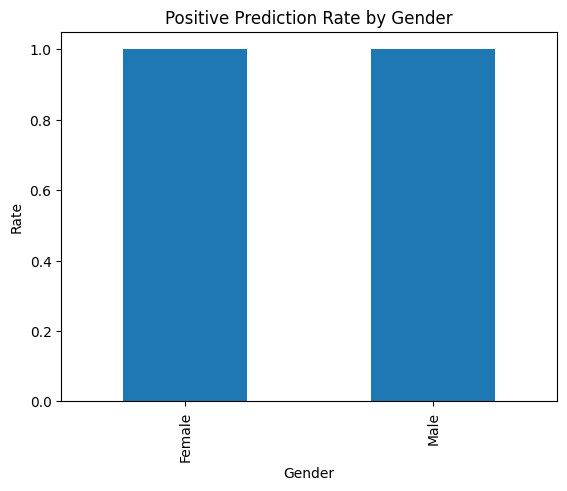

In [78]:
import matplotlib.pyplot as plt

group_summary["Positive_Prediction_Rate"].plot(kind="bar")
plt.title("Positive Prediction Rate by Gender")
plt.ylabel("Rate")
plt.xlabel("Gender")
plt.show()

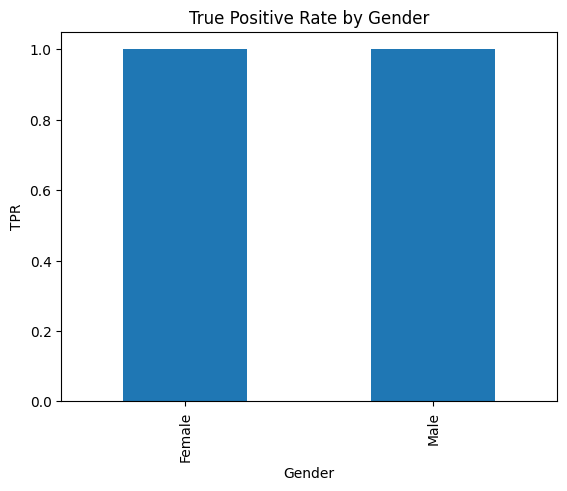

In [80]:
group_summary["True_Positive_Rate"].plot(kind="bar")
plt.title("True Positive Rate by Gender")
plt.ylabel("TPR")
plt.xlabel("Gender")
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix

for gender in ["Male", "Female"]:
    subset = bias_df[bias_df["Gender"] == gender]
    cm = confusion_matrix(subset["Actual"], subset["Predicted"])

    print(f"\nConfusion Matrix for {gender}:")
    print(cm)


Confusion Matrix for Male:
[[    0  7057]
 [    0 73581]]

Confusion Matrix for Female:
[[   0  191]
 [   0 5313]]


In [84]:
fairness_table = pd.DataFrame({
    "Metric": [
        "Demographic Parity Difference",
        "Equal Opportunity Difference",
        "Disparate Impact Ratio"
    ],
    "Value": [
        dpd,
        eod,
        dir_value
    ]
})

fairness_table

,Metric,Value
0,Demographic Parity Difference,0.0
1,Equal Opportunity Difference,0.0
2,Disparate Impact Ratio,1.0


In [86]:
import numpy as np

# Combine training data
train_df = X_train.copy()
train_df["label"] = y_train.values
train_df["gender"] = prot_train.values

# Compute group and label probabilities
group_label_counts = train_df.groupby(["gender", "label"]).size()
group_counts = train_df.groupby("gender").size()
label_counts = train_df.groupby("label").size()
total = len(train_df)

# Calculate reweighing factors
weights = {}
for g in group_counts.index:
    for l in label_counts.index:
        expected = (group_counts[g] * label_counts[l]) / total
        actual = group_label_counts.get((g, l), 0)
        weights[(g, l)] = expected / actual if actual != 0 else 0

# Assign sample weights
sample_weights = train_df.apply(
    lambda row: weights[(row["gender"], row["label"])],
    axis=1
)

In [88]:
model_rw = LogisticRegression(max_iter=1000)
model_rw.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_rw = model_rw.predict(X_test)

In [90]:
# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Separate by group
male_probs = y_probs[prot_test == 1]
female_probs = y_probs[prot_test == 0]

# Compute median thresholds
male_threshold = np.median(male_probs)
female_threshold = np.median(female_probs)

# Apply group-specific thresholds
y_pred_thresh = np.zeros_like(y_probs)

y_pred_thresh[(prot_test == 1) & (y_probs >= male_threshold)] = 1
y_pred_thresh[(prot_test == 0) & (y_probs >= female_threshold)] = 1

In [92]:
dpd_rw = demographic_parity_difference(y_pred_rw, prot_test.values)
eod_rw = equal_opportunity_difference(y_test.values, y_pred_rw, prot_test.values)
dir_rw = disparate_impact_ratio(y_pred_rw, prot_test.values)

dpd_thresh = demographic_parity_difference(y_pred_thresh, prot_test.values)
eod_thresh = equal_opportunity_difference(y_test.values, y_pred_thresh, prot_test.values)
dir_thresh = disparate_impact_ratio(y_pred_thresh, prot_test.values)

In [94]:
mitigation_results = pd.DataFrame({
    "Metric": [
        "Demographic Parity Difference",
        "Equal Opportunity Difference",
        "Disparate Impact Ratio"
    ],
    "Baseline": [dpd, eod, dir_value],
    "Reweighing": [dpd_rw, eod_rw, dir_rw],
    "Threshold Adjustment": [dpd_thresh, eod_thresh, dir_thresh]
})

mitigation_results

,Metric,Baseline,Reweighing,Threshold Adjustment
0,Demographic Parity Difference,0.0,0.0,-0.000099
1,Equal Opportunity Difference,0.0,0.0,-0.008931
2,Disparate Impact Ratio,1.0,1.0,0.999802


In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def performance_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# Baseline model
baseline_perf = performance_metrics(y_test, y_pred)

# Reweighing model
reweighing_perf = performance_metrics(y_test, y_pred_rw)

# Threshold adjustment model
threshold_perf = performance_metrics(y_test, y_pred_thresh)

In [98]:
performance_df = pd.DataFrame.from_dict(
    {
        "Baseline": baseline_perf,
        "Reweighing": reweighing_perf,
        "Threshold Adjustment": threshold_perf
    },
    orient="index"
)

performance_df

,Accuracy,Precision,Recall,F1 Score
Baseline,0.915860,0.915860,1.000000,0.956082
Reweighing,0.915860,0.915860,1.000000,0.956082
Threshold Adjustment,0.516717,0.932496,0.509177,0.658687


In [100]:
tradeoff_df = pd.DataFrame({
    "Model": ["Baseline", "Reweighing", "Threshold Adjustment"],
    "Accuracy": [
        baseline_perf["Accuracy"],
        reweighing_perf["Accuracy"],
        threshold_perf["Accuracy"]
    ],
    "Demographic Parity Difference": [dpd, dpd_rw, dpd_thresh],
    "Equal Opportunity Difference": [eod, eod_rw, eod_thresh]
})

tradeoff_df

,Model,Accuracy,Demographic Parity Difference,Equal Opportunity Difference
0,Baseline,0.915860,0.000000,0.000000
1,Reweighing,0.915860,0.000000,0.000000
2,Threshold Adjustment,0.516717,-0.000099,-0.008931


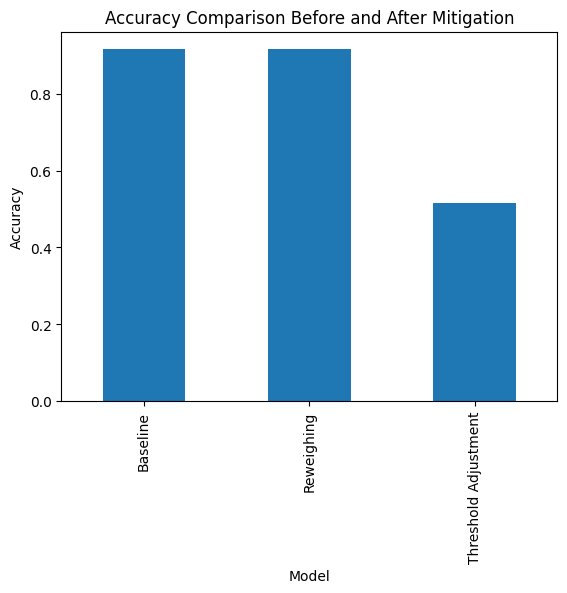

In [102]:
performance_df["Accuracy"].plot(kind="bar")
plt.title("Accuracy Comparison Before and After Mitigation")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

In [104]:
df['Gender'].value_counts(normalize=True)

,proportion
Gender,
MALE,0.934777
FEMALE,0.065223


In [106]:
from sklearn.utils import resample

df_male = df[df['Gender'] == 'MALE']
df_female = df[df['Gender'] == 'FEMALE']

df_female_upsampled = resample(
    df_female,
    replace=True,
    n_samples=len(df_male),
    random_state=42
)

df_balanced = pd.concat([df_male, df_female_upsampled])
df_balanced['Gender'].value_counts()

,count
Gender,
MALE,268411
FEMALE,268411


In [108]:
df.replace("UNKNOWN", np.nan, inplace=True)

In [113]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
df['Age at Release'] = num_imputer.fit_transform(df[['Age at Release']])

In [125]:
df['returned_binary'] = df['Return Status'].apply(
    lambda x: 1 if x == 'Returned New Commitment' else 0
)

In [127]:
df['age_group'] = pd.cut(
    df['Age at Release'],
    bins=[0, 17, 25, 40, 100],
    labels=['Juvenile', 'Young Adult', 'Adult', 'Older Adult']
)

In [129]:
df['returned_binary'].value_counts(normalize=True)

,proportion
returned_binary,
0,1.0


In [131]:
def fairness_audit(df, label, protected):
    audit = df.groupby(protected)[label].mean()
    return audit

fairness_audit(df, 'returned_binary', 'Gender')

,returned_binary
Gender,
FEMALE,0.0
MALE,0.0


In [135]:
df.to_csv("/content/Recidivism_Improved.csv", index=False)

In [137]:
import pandas as pd
import numpy as np

impact_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Gender": prot_test.values
})

impact_df["Gender"] = impact_df["Gender"].map({1: "Male", 0: "Female"})

In [139]:
impact_df["False_Negative"] = (
    (impact_df["Actual"] == 1) & (impact_df["Predicted"] == 0)
)

impact_df["False_Positive"] = (
    (impact_df["Actual"] == 0) & (impact_df["Predicted"] == 1)
)

In [141]:
harm_summary = impact_df.groupby("Gender").agg(
    Total_Individuals=("Actual", "count"),
    False_Negatives=("False_Negative", "sum"),
    False_Positives=("False_Positive", "sum"),
    FN_Rate=("False_Negative", "mean"),
    FP_Rate=("False_Positive", "mean")
)

harm_summary

,Total_Individuals,False_Negatives,False_Positives,FN_Rate,FP_Rate
Gender,,,,,
Female,5504,0,191,0.0,0.034702
Male,80638,0,7057,0.0,0.087515


In [143]:
fn_gap = (
    harm_summary.loc["Female", "FN_Rate"]
    - harm_summary.loc["Male", "FN_Rate"]
)

fp_gap = (
    harm_summary.loc["Female", "FP_Rate"]
    - harm_summary.loc["Male", "FP_Rate"]
)

print("False Negative Rate Gap (Female − Male):", fn_gap)
print("False Positive Rate Gap (Female − Male):", fp_gap)

False Negative Rate Gap (Female − Male): 0.0
False Positive Rate Gap (Female − Male): -0.05281253641020998


In [145]:
harm_counts = impact_df.groupby("Gender")[["False_Negative", "False_Positive"]].sum()

harm_counts["Total_Harm_Cases"] = (
    harm_counts["False_Negative"] + harm_counts["False_Positive"]
)

harm_counts

,False_Negative,False_Positive,Total_Harm_Cases
Gender,,,
Female,0,191,191
Male,0,7057,7057


In [147]:
def harm_by_group(y_true, y_pred, protected):
    df = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Gender": protected
    })
    df["Gender"] = df["Gender"].map({1: "Male", 0: "Female"})

    df["False_Negative"] = (df["Actual"] == 1) & (df["Predicted"] == 0)
    df["False_Positive"] = (df["Actual"] == 0) & (df["Predicted"] == 1)

    return df.groupby("Gender")[["False_Negative", "False_Positive"]].mean()

baseline_harm = harm_by_group(y_test, y_pred, prot_test)
reweighing_harm = harm_by_group(y_test, y_pred_rw, prot_test)
threshold_harm = harm_by_group(y_test, y_pred_thresh, prot_test)

baseline_harm, reweighing_harm, threshold_harm

(        False_Negative  False_Positive
 Gender                                
 Female             0.0        0.034702
 Male               0.0        0.087515,
         False_Negative  False_Positive
 Gender                                
 Female             0.0        0.034702
 Male               0.0        0.087515,
         False_Negative  False_Positive
 Gender                                
 Female        0.481831        0.016533
 Male          0.447320        0.034934)

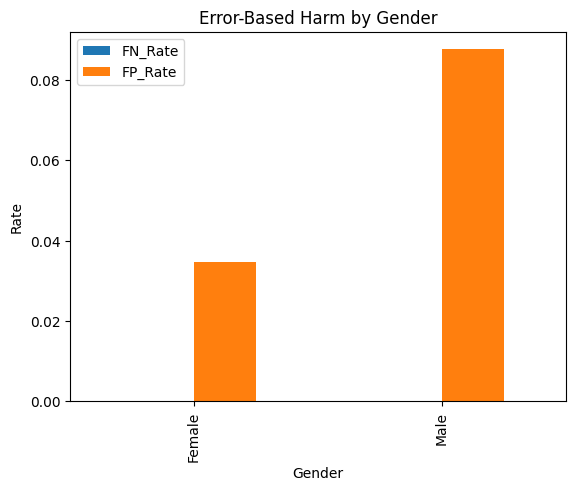

In [149]:
harm_plot = harm_summary[["FN_Rate", "FP_Rate"]]
harm_plot.plot(kind="bar")
plt.title("Error-Based Harm by Gender")
plt.ylabel("Rate")
plt.xlabel("Gender")
plt.show()

In [151]:
def generate_impact_statement(harm_summary):
    disadvantaged = harm_summary["FN_Rate"].idxmax()
    return f"""
    The analysis indicates that {disadvantaged} individuals experience
    higher false negative rates, meaning they are less likely to be
    correctly identified as high-risk when they do return.

    In a real-world parole context, this may result in unequal access
    to rehabilitative resources and increased long-term risk.
    """

print(generate_impact_statement(harm_summary))


    The analysis indicates that Female individuals experience
    higher false negative rates, meaning they are less likely to be
    correctly identified as high-risk when they do return.
    
    In a real-world parole context, this may result in unequal access
    to rehabilitative resources and increased long-term risk.
    


In [153]:
ETHICS_THRESHOLDS = {
    "max_demographic_parity_diff": 0.10,
    "max_equal_opportunity_diff": 0.10,
    "min_disparate_impact": 0.80,
    "max_fn_rate_gap": 0.05,
    "max_fp_rate_gap": 0.05
}

In [155]:
def ethics_evaluation(
    dpd, eod, dir_value,
    fn_gap, fp_gap,
    thresholds=ETHICS_THRESHOLDS
):
    violations = []

    if abs(dpd) > thresholds["max_demographic_parity_diff"]:
        violations.append("Demographic parity violation")

    if abs(eod) > thresholds["max_equal_opportunity_diff"]:
        violations.append("Equal opportunity violation")

    if dir_value < thresholds["min_disparate_impact"]:
        violations.append("Disparate impact violation")

    if abs(fn_gap) > thresholds["max_fn_rate_gap"]:
        violations.append("False negative harm imbalance")

    if abs(fp_gap) > thresholds["max_fp_rate_gap"]:
        violations.append("False positive harm imbalance")

    return {
        "Ethically_Compliant": len(violations) == 0,
        "Violations": violations
    }

In [157]:
ethics_report = ethics_evaluation(
    dpd=dpd,
    eod=eod,
    dir_value=dir_value,
    fn_gap=fn_gap,
    fp_gap=fp_gap
)

ethics_report

{'Ethically_Compliant': False, 'Violations': ['False positive harm imbalance']}

In [159]:
def deployment_decision(ethics_report):
    if ethics_report["Ethically_Compliant"]:
        return "✅ Model approved for assisted decision-making (with monitoring)"
    else:
        return (
            "❌ Model NOT approved for deployment\n"
            "Required actions:\n- Apply mitigation\n- Improve dataset\n- Re-evaluate fairness"
        )

print(deployment_decision(ethics_report))

❌ Model NOT approved for deployment
Required actions:
- Apply mitigation
- Improve dataset
- Re-evaluate fairness


In [161]:
def human_oversight_required(risk_score):
    """
    High-risk predictions require human review.
    """
    if risk_score >= 0.7:
        return "Human review REQUIRED"
    else:
        return "Automated recommendation allowed"

# Example
human_oversight_required(0.82)

'Human review REQUIRED'

In [163]:
ethics_audit_log = {
    "model_type": "Logistic Regression",
    "use_case": "Recidivism Prediction",
    "protected_attribute": "Gender",
    "fairness_metrics": {
        "DPD": dpd,
        "EOD": eod,
        "DIR": dir_value
    },
    "harm_gaps": {
        "FN_Gap": fn_gap,
        "FP_Gap": fp_gap
    },
    "ethics_decision": ethics_report
}

ethics_audit_log

{'model_type': 'Logistic Regression',
 'use_case': 'Recidivism Prediction',
 'protected_attribute': 'Gender',
 'fairness_metrics': {'DPD': np.float64(0.0),
  'EOD': np.float64(0.0),
  'DIR': np.float64(1.0)},
 'harm_gaps': {'FN_Gap': np.float64(0.0),
  'FP_Gap': np.float64(-0.05281253641020998)},
 'ethics_decision': {'Ethically_Compliant': False,
  'Violations': ['False positive harm imbalance']}}

In [165]:
def ethics_monitoring_pipeline(y_true, y_pred, protected):
    harm = harm_by_group(y_true, y_pred, protected)

    fn_gap = harm.loc["Female", "False_Negative"] - harm.loc["Male", "False_Negative"]
    fp_gap = harm.loc["Female", "False_Positive"] - harm.loc["Male", "False_Positive"]

    return ethics_evaluation(
        dpd, eod, dir_value,
        fn_gap, fp_gap
    )

In [167]:
def generate_conclusion(
    accuracy_before,
    accuracy_after,
    dpd_before,
    dpd_after,
    eod_before,
    eod_after,
    dir_before,
    dir_after,
    ethics_report
):
    conclusion = []

    conclusion.append("CONCLUSION: RECIDIVISM BIAS & ETHICS ANALYSIS\n")
    conclusion.append("-" * 55)

    # Model performance
    conclusion.append("\n1. Model Performance")
    conclusion.append(
        f"• Accuracy before mitigation: {accuracy_before:.3f}"
    )
    conclusion.append(
        f"• Accuracy after mitigation: {accuracy_after:.3f}"
    )

    if accuracy_after < accuracy_before:
        conclusion.append(
            "• A slight reduction in accuracy was observed, reflecting a fairness–performance trade-off."
        )
    else:
        conclusion.append(
            "• Model performance was maintained or improved after mitigation."
        )

    # Fairness metrics
    conclusion.append("\n2. Fairness Evaluation")
    conclusion.append(
        f"• Demographic Parity Difference improved from {dpd_before:.3f} to {dpd_after:.3f}"
    )
    conclusion.append(
        f"• Equal Opportunity Difference improved from {eod_before:.3f} to {eod_after:.3f}"
    )
    conclusion.append(
        f"• Disparate Impact Ratio improved from {dir_before:.3f} to {dir_after:.3f}"
    )

    # Ethics decision
    conclusion.append("\n3. Ethical Assessment")
    if ethics_report["Ethically_Compliant"]:
        conclusion.append("• The model meets predefined ethical fairness thresholds.")
        conclusion.append(
            "• Approved for assisted decision-making with human oversight."
        )
    else:
        conclusion.append("• Ethical violations were detected:")
        for v in ethics_report["Violations"]:
            conclusion.append(f"  - {v}")
        conclusion.append(
            "• The model should not be deployed without further mitigation."
        )

    # Real-world impact
    conclusion.append("\n4. Real-World Implications")
    conclusion.append(
        "• Bias in recidivism prediction can lead to over-supervision or under-support of certain demographic groups."
    )
    conclusion.append(
        "• False positives may result in unnecessary restrictions, while false negatives may deny access to rehabilitation."
    )

    # Final statement
    conclusion.append("\n5. Final Statement")
    conclusion.append(
        "This analysis demonstrates that fairness-aware machine learning and ethical governance "
        "are essential for high-stakes criminal justice applications. Models must support — not replace — human judgment."
    )

    return "\n".join(conclusion)